In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.path as mplPath
import xml.etree.ElementTree as ET
import util
from skimage import img_as_ubyte
from skimage.segmentation import find_boundaries
from timeit import default_timer as timer
from datetime import datetime
from skimage.transform import rescale

In [2]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
ximg_train = []; ximg_test = []; ximg_validation = [];
ximg_train_superpixels = [];
ximg_test_superpixels = [];
ximg_validation_superpixels = [];
ximgresized_train = []; ximgresized_test = []; ximgresized_validation = [];
xgt_train = []; xgt_test = []; xgt_validation = [];
x_train = []; y_train = []
x_test = []; y_test = []
x_va = []; y_va = []
x = []; y = []


#### Leyendo las imágenes de los documentos y sus respectivos archivos XML que contienen los segmentos (ground truth) como coordenadas de polígonos


In [3]:
startTime = datetime.now()   
ximg_train,      xgt_train      = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'train')     
ximg_test,       xgt_test       = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test')
ximg_validation, xgt_validation = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'validation')
print("Time taken:", datetime.now() - startTime)

Time taken: 0:00:12.193988


index 7 to samples

#### Segmentando las imágenes en super píxeles, usando la técnica  SLIC

In [4]:
#a list of lists
import importlib
importlib.reload(util)
startTime = datetime.now()
ximg_train_superpixels = util.segmentImageInSuperpixels([ximg_train[7]], 3000)
print("Time taken:", datetime.now() - startTime)    

Time taken: 0:02:40.514166


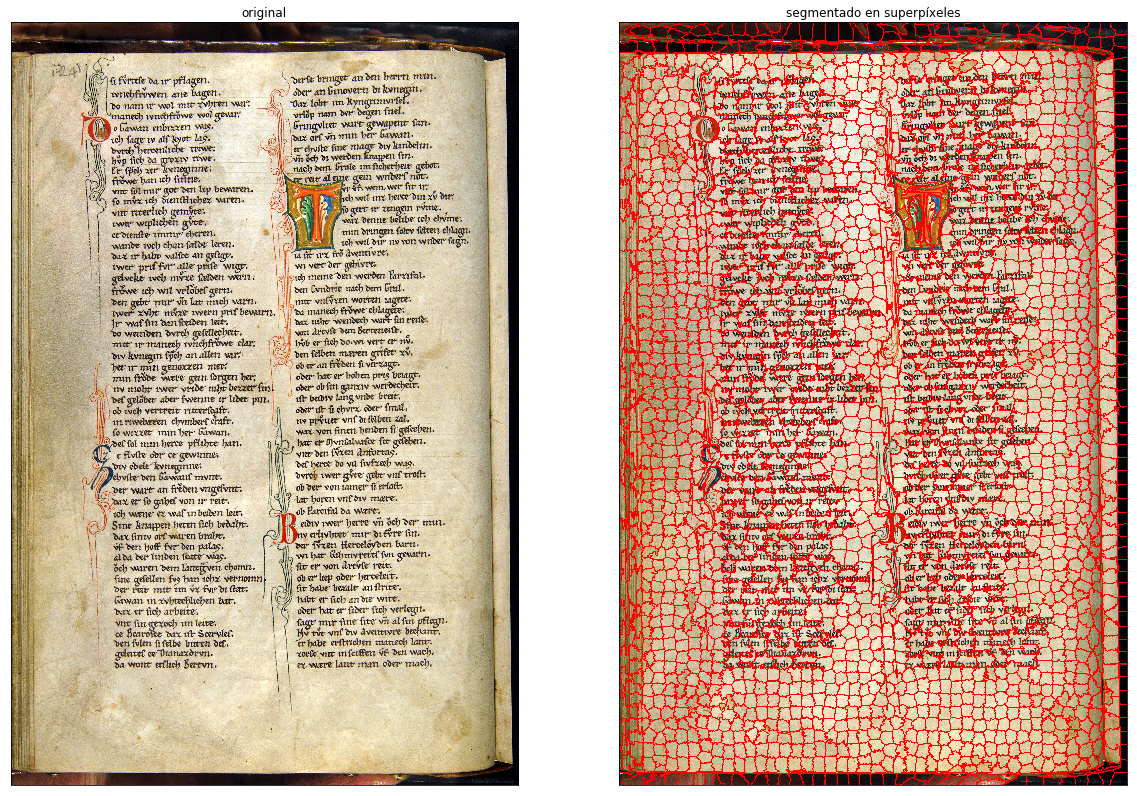

Time taken: 0:00:02.532220


In [5]:
startTime = datetime.now()
image = ximg_train[7]
imgSegmented = mark_boundaries(image.copy(), ximg_train_superpixels[0], color=(1, 0, 0), outline_color=(1, 0, 0))
util.subplot(titles=['original','segmentado en superpíxeles'], images = [image, imgSegmented], rows = 1, imgPerRows = 2, size = 20)
print("Time taken:", datetime.now() - startTime)        

In [6]:
startTime = datetime.now()
imagePoints = imgSegmented.copy()
util.paintCentralPointsOrPatchesSegments (imagePoints , ximg_train_superpixels[0], 6, 0, False)
print("Time taken:", datetime.now() - startTime)            

Time taken: 0:00:38.482569


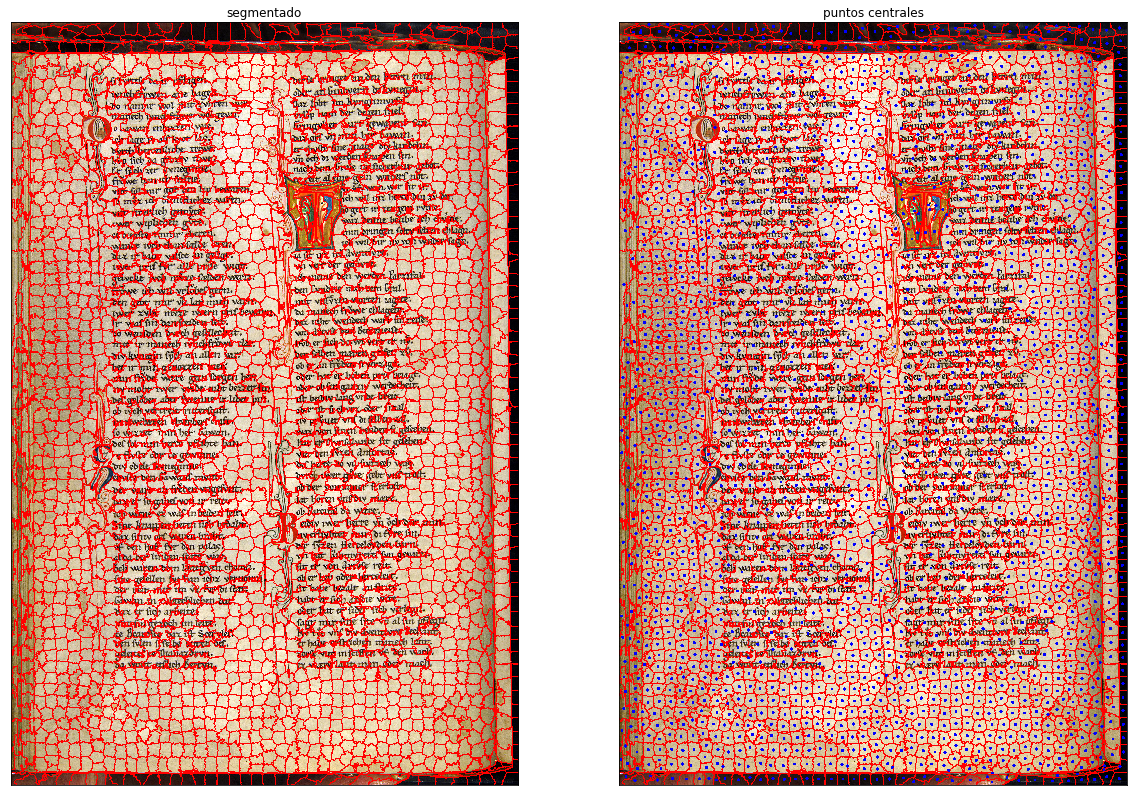

Time taken: 0:00:01.554124


In [7]:
startTime = datetime.now()
util.subplot(titles=['segmentado','puntos centrales'], images = [imgSegmented, imagePoints], rows = 1, imgPerRows = 2, size = 20)
print("Time taken:", datetime.now() - startTime)  

In [9]:
# image, segments, radio, sizePatch, isPatch
import importlib
importlib.reload(util)

startTime = datetime.now()
imagePatches = imagePoints.copy()
#imagePatches = img_as_ubyte(imagePatches)
util.paintCentralPointsOrPatchesSegments (imagePatches , ximg_train_superpixels[0], 0, 28, True)
print("Time taken:", datetime.now() - startTime)      

Time taken: 0:00:38.687379


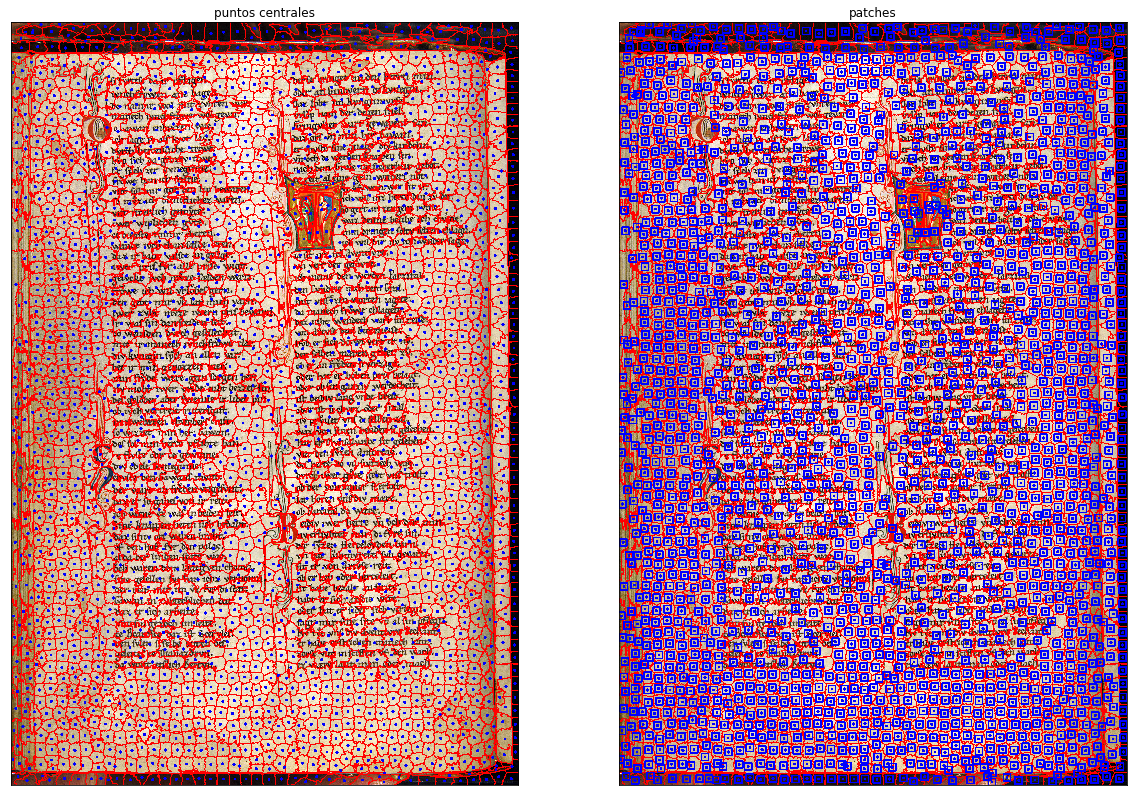

In [10]:
util.subplot(titles=['puntos centrales','patches'], images = [imagePoints, imagePatches], rows = 1, imgPerRows = 2, size = 20)

### Obteniendo los super píxeles para todas las imágenes de entrenamiento, test y validación

In [ ]:
#ximg_train_superpixels      = util2.segmentImageInSuperpixels([ximg_train[7]], 3000)
#ximg_test_superpixels       = Util.segmentImageInSuperpixels([ximg_test[0]], 3000)
#ximg_validation_superpixels = Util.segmentImageInSuperpixels([ximg_validation[0]], 3000)

### Generando los ejemplares de entrenamiento con sus respectivos puntos centrales y superpíxel asociado 

In [11]:
import importlib
importlib.reload(util)
startTime = datetime.now()
XTrain, XCentralPoints, listSuperPixelesProcessed = util.doInputs([ximg_train[7]], ximg_train_superpixels, 28)
print("Time taken:", datetime.now() - startTime)          

Time taken: 0:00:41.489714


In [12]:
print(len(XTrain[0]))
print(len(listSuperPixelesProcessed[0]))
print(np.shape(XCentralPoints[0]))


2041
2041
(2041, 2)


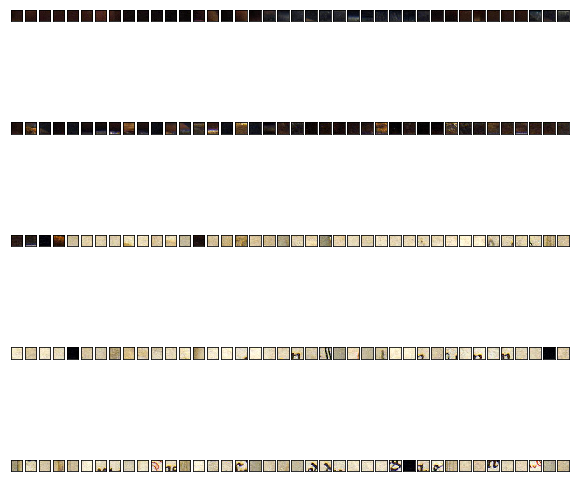

Time taken: 0:00:12.780357


In [13]:
startTime = datetime.now()
fig, ax = plt.subplots(figsize=(10,10))
for i in range(200):
    plt.subplot(5,40,i+1),plt.imshow(XTrain[0][i],'gray')
    plt.title("")
    plt.xticks([]),plt.yticks([])
plt.show()
print("Time taken:", datetime.now() - startTime)     

### Obteniendo las clases o etiquetas por cada ejemplar de entrenamiento (patch)

In [14]:
startTime = datetime.now()
Y = util.doLabels([XCentralPoints[0]], [xgt_train[7]], folderGroundThruth, 'train')
print("Time taken:", datetime.now() - startTime)         

Time taken: 0:02:11.802161


In [15]:
print(np.shape(XTrain[0]))
print(np.shape(Y[0]))


(2041, 28, 28, 3)
(2041,)


In [16]:
from collections import Counter
Counter(Y[0])


Counter({'decoration': 99, 'page': 1185, 'periphery': 185, 'text': 572})

In [17]:
startTime = datetime.now()
image = ximg_train[7]
vis = np.zeros(image.shape[:2], dtype="float")
superpixels = listSuperPixelesProcessed[0]
print(len(superpixels))
for i in range(len(superpixels)) :
    if Y[0][i] == 'text' :    
        vis[superpixels[i] == 255] = 0.2
    elif Y[0][i] == 'decoration' :
        vis[superpixels[i] == 255] = 0.4
    elif Y[0][i] == 'comment' :
        vis[superpixels[i] == 255] = 0.6
    elif Y[0][i] == 'page' :
        vis[superpixels[i] == 255] = 0.8
    elif Y[0][i] == 'periphery' :
        vis[superpixels[i] == 255] = 1        
                    

2041


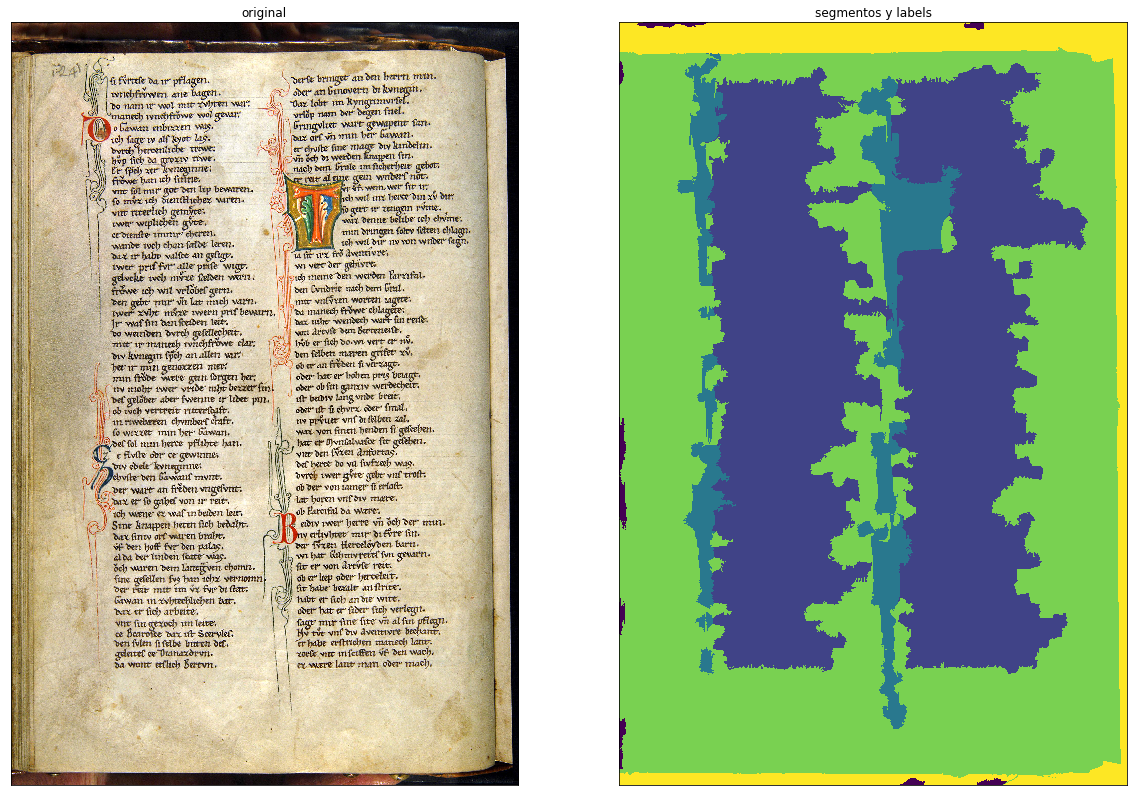

In [18]:
util.subplot(titles=['original','segmentos y labels'], images = [image, vis], rows = 1, imgPerRows = 2, size = 20)
